<h3> Importing the required libraries

In [326]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, f1_score, classification_report, mean_absolute_error, log_loss
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

<h3>Import data

In [327]:
# Đọc dữ liệu từ file fraud_transaction.csv
df = pd.read_csv('./fraud_transactions.csv')

<h3>Understanding the data

In [328]:
df.head()

,amount,method,surplus,type,year,month,day,hour,minute,isFraud
0,40297619.0,Credit Card,32858073.0,mua nhà,2024,11,23,15,2,0
1,1091485.0,Credit Card,13747389.0,thanh toán hóa đơn,2023,4,4,10,14,0
2,5005293.0,Debit Card,13545160.0,mua cổ phiếu,2023,12,10,21,50,0
3,8537869.0,Wire Transfer,36265517.0,mua sắm,2024,10,27,9,17,1
4,24093031.0,ATM Card,355742.0,thanh toán hóa đơn,2023,7,3,4,53,0


In [329]:
# Các trường của dữ liệu
df.columns

Index(['amount', 'method', 'surplus', 'type', 'year', 'month', 'day', 'hour',
       'minute', 'isFraud'],
      dtype='object')

In [330]:
print(df.shape)       
print(df.info())

(999, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   amount   999 non-null    float64
 1   method   999 non-null    object 
 2   surplus  999 non-null    float64
 3   type     999 non-null    object 
 4   year     999 non-null    int64  
 5   month    999 non-null    int64  
 6   day      999 non-null    int64  
 7   hour     999 non-null    int64  
 8   minute   999 non-null    int64  
 9   isFraud  999 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 78.2+ KB
None


In [331]:
# Các mô tả thống kê với các biến dạng numerical
df.describe()

,amount,surplus,year,month,day,hour,minute,isFraud
count,9.990000e+02,9.990000e+02,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,2.514194e+07,2.546516e+07,2023.488488,6.589590,14.894895,11.236236,29.063063,0.174174
std,1.445737e+07,1.447440e+07,0.500118,3.440553,8.606748,6.642175,16.922463,0.379449
min,1.883100e+04,4.787100e+04,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.263940e+07,1.308947e+07,2023.000000,4.000000,8.000000,5.000000,15.000000,0.000000
50%,2.476640e+07,2.588624e+07,2023.000000,7.000000,15.000000,11.000000,29.000000,0.000000
75%,3.808591e+07,3.772763e+07,2024.000000,9.000000,22.000000,17.000000,44.000000,0.000000
max,4.996429e+07,4.994827e+07,2024.000000,12.000000,29.000000,22.000000,58.000000,1.000000


<h3>Split the Dataset into Training Data and Test Data

In [332]:
y = df["isFraud"]                   # y là các giá trị cột BAD
X = df.drop(["isFraud"],axis=1)     # X là các cột còn lại

In [333]:
# split dataframe
x_train, x_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=0, test_size=0.3)

In [334]:
print("Train:",x_train.shape)
print("Test:",x_test.shape)

Train: (699, 9)
Test: (300, 9)


In [335]:
y_train.value_counts()

0    577
1    122
Name: isFraud, dtype: int64

In [336]:
y_test.value_counts()   

0    248
1     52
Name: isFraud, dtype: int64

<h3>Distribution of variables on datesets

In [337]:
def distribution_numerical(column):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Vẽ đồ thị histogram và đường KDE cho tập train
    sns.histplot(x_train[column], bins=15, kde=True, ax=axes[0])
    axes[0].set_title(f"Phân phối của {column} trên tập train")
    axes[0].set_ylabel("Tần suất")
    axes[0].set_xlabel(None)
    axes[0].text(0.95, 0.9, f"Skewness: {x_train[column].skew():.2f}", transform=axes[0].transAxes,
                                horizontalalignment='right', fontsize=12, color='red')

    # Vẽ đồ thị histogram và đường KDE cho test
    sns.histplot(x_test[column], bins=15, kde=True, ax=axes[1])
    axes[1].set_title(f"Phân phối của {column} trên tập test")
    axes[1].set_ylabel("Tần suất")
    axes[1].set_xlabel(None)
    axes[1].text(0.95, 0.9, f"Skewness: {x_test[column].skew():.2f}", transform=axes[1].transAxes,
                                horizontalalignment='right', fontsize=12, color='red')

    # Căn chỉnh và hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

In [338]:
def distribution_category(column, data_train, data_test):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Vẽ biểu đồ cột thứ nhất
    axes[0].barh(data_train.value_counts().keys().astype('str'), data_train.value_counts().values, color='orange', height = .4)
    axes[0].set_title(f"Phân phối của {column} trên tập train")
    axes[0].set_xlabel(None)
    axes[0].set_ylabel("Danh mục")

    # Vẽ biểu đồ cột thứ hai
    axes[1].barh(data_test.value_counts().keys().astype('str'), data_test.value_counts().values, color='orange', height = .4)
    axes[1].set_title(f"Phân phối của {column} trên tập test")
    axes[1].set_xlabel(None)
    axes[1].set_ylabel(None)

    # Đảo ngược trục y
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()

    for i, count in enumerate(data_train.value_counts()):
        axes[0].text(count, i, str(count), ha="left", va="center", fontweight="bold")
    for i, count in enumerate(data_test.value_counts()):
        axes[1].text(count, i, str(count), ha="left", va="center", fontweight="bold")

    # Căn chỉnh và hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

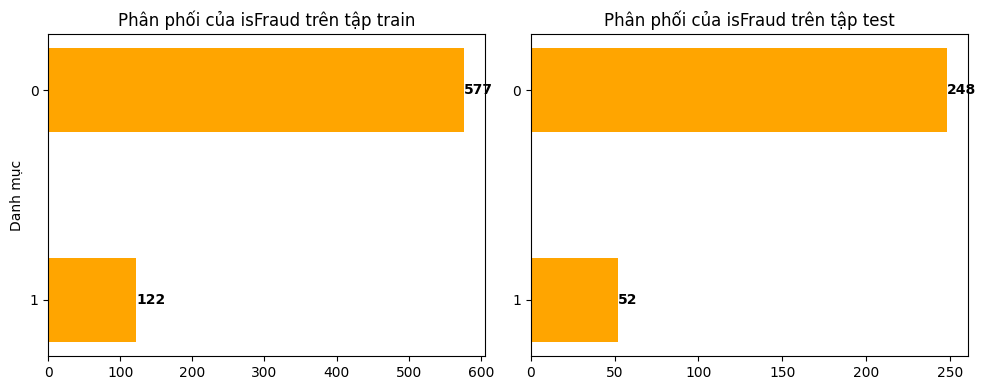

In [339]:
distribution_category("isFraud", y_train, y_test)

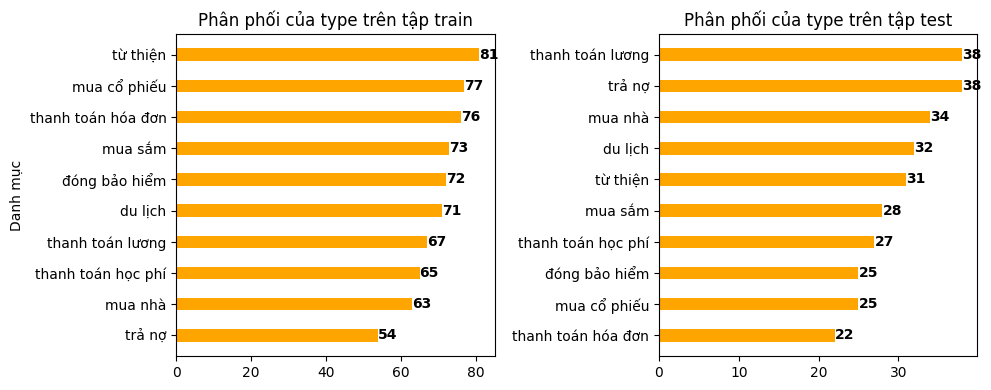

In [340]:
distribution_category('type', x_train['type'], x_test['type'])

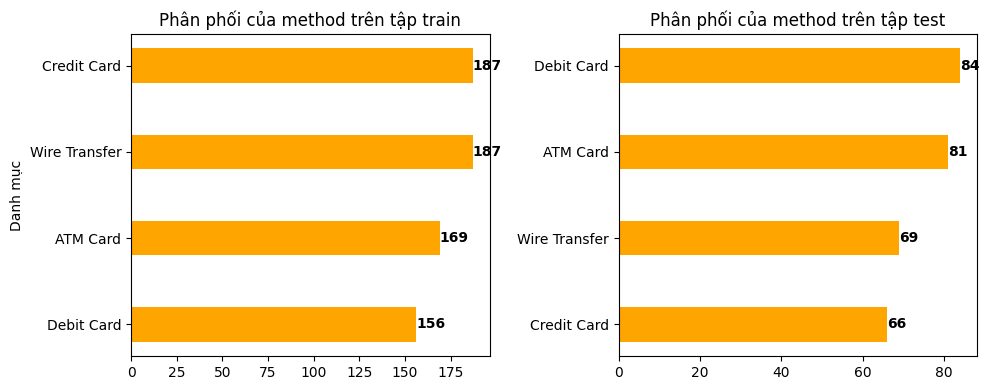

In [341]:
distribution_category('method', x_train['method'], x_test['method'])

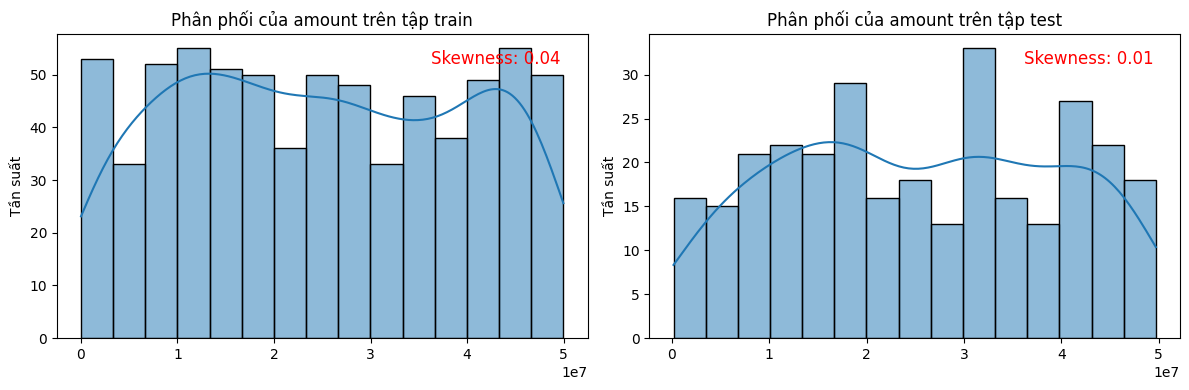

In [342]:
distribution_numerical('amount')

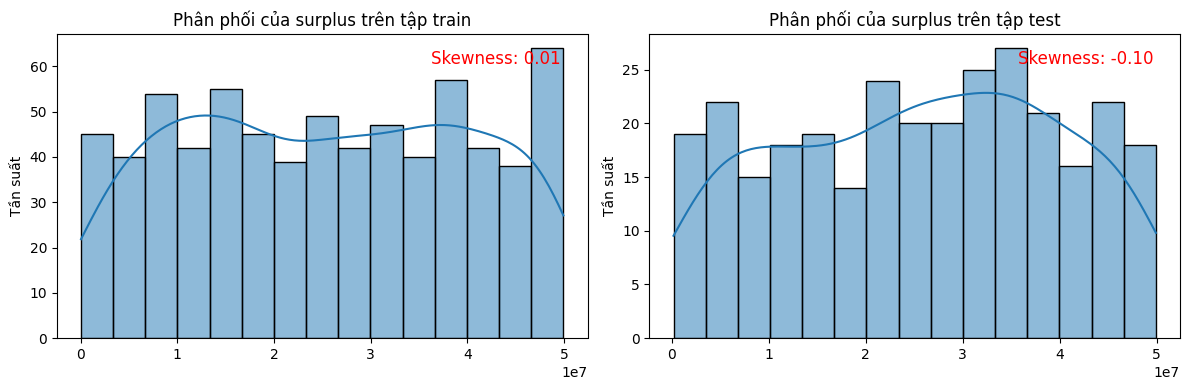

In [343]:
distribution_numerical('surplus')

<h3>Correlation between variables

C:\Users\thang\AppData\Local\Temp\ipykernel_10928\3180651175.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = round(data_corr.corr(),2)


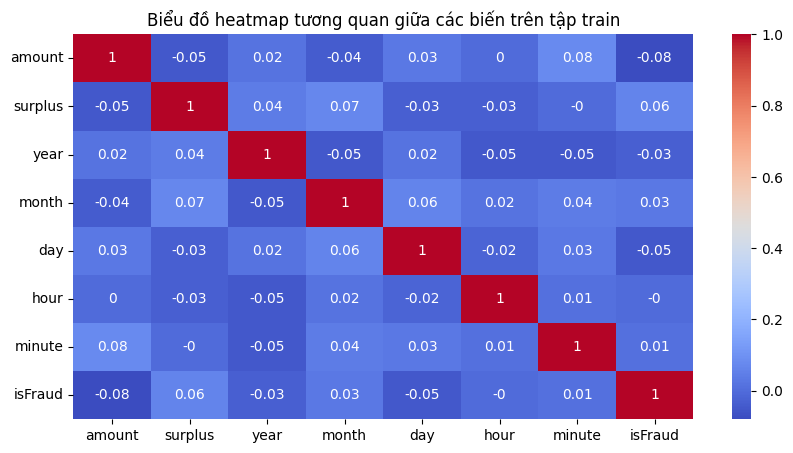

In [344]:
data_corr = x_train.copy()
data_corr["isFraud"] = y_train

plt.figure(figsize=(10,5))
# Tạo ma trận tương quan
corr_matrix = round(data_corr.corr(),2)

# Vẽ biểu đồ heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Tùy chỉnh các thông số trên biểu đồ
plt.title("Biểu đồ heatmap tương quan giữa các biến trên tập train")

# Hiển thị biểu đồ
plt.show()

In [345]:
def relationship_variable_with_target(data):
    # Create subplots for bar plots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    fig.suptitle("Relationships between 'isFraud' and Different Features", fontsize=16)

    # Bar plot for 'method'
    method=pd.crosstab(data['method'],data['isFraud'])
    method.div(method.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='Method vs isFraud', ax = axes[0,0])

    # Bar plot for 'type'
    type=pd.crosstab(data['type'],data['isFraud'])
    type.div(type.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='Type vs isFraud', ax = axes[0,1])

    # Bar plot for 'year'
    year=pd.crosstab(data['year'],data['isFraud'])
    year.div(year.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='Year vs BAD', ax = axes[1,0])

    # Bar plot for 'month'
    month=pd.crosstab(data['month'],data['isFraud'])
    month.div(month.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='Month vs isFraud', ax = axes[1,1])

    # Bar plot for 'day'
    day=pd.crosstab(data['day'],data['isFraud'])
    day.div(day.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='Day vs isFraud', ax = axes[2,0])

    # Bar plot for 'hour'
    hour=pd.crosstab(data['hour'],data['isFraud'])
    hour.div(hour.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='Hour vs isFraud', ax = axes[2,1])

    # Adjust layout and display plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

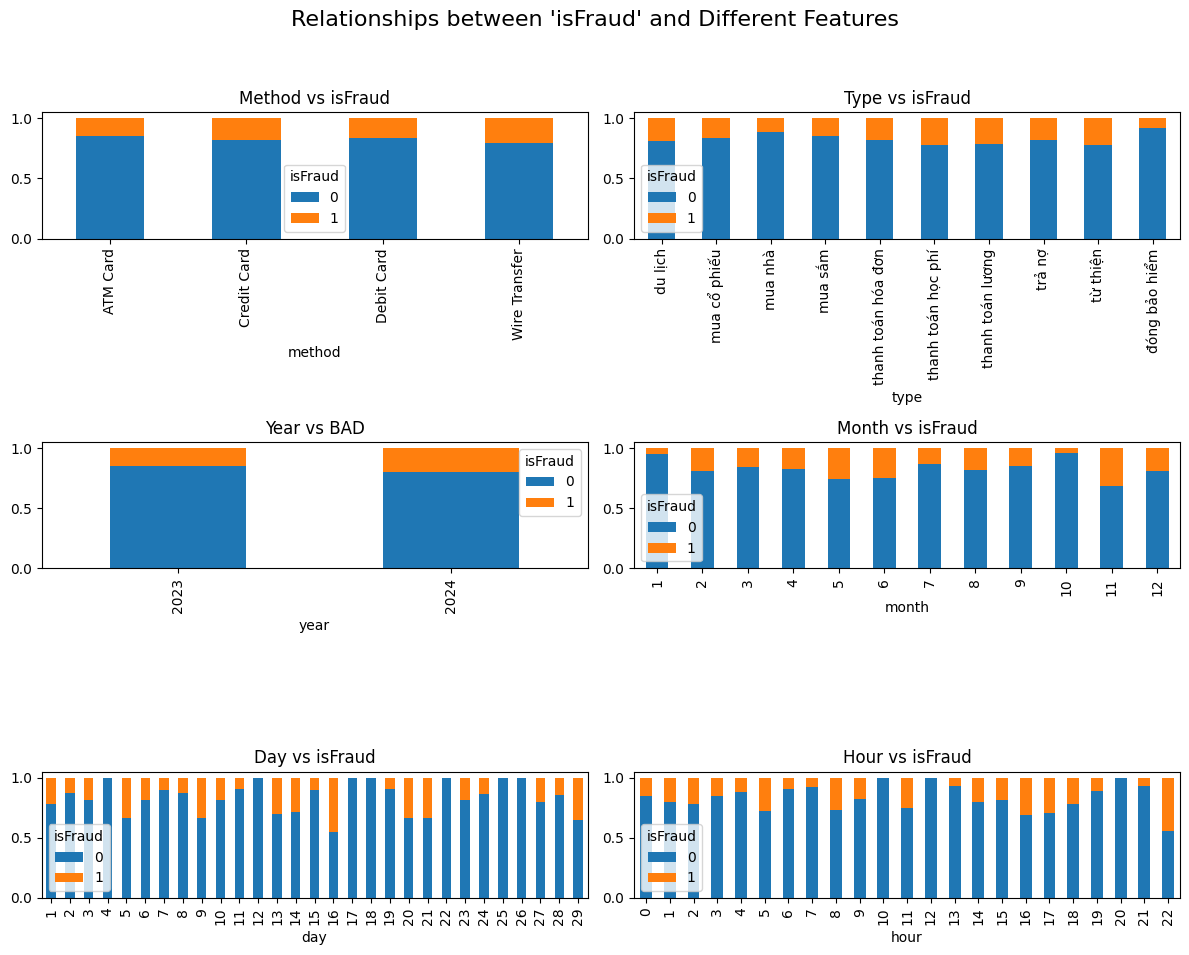

In [346]:
data_corr_test = x_test.copy()
data_corr_test["isFraud"] = y_test
relationship_variable_with_target(data_corr_test)

<h3>Data Preprocessing</h3>

In [347]:
print("Data duplicated on train dataset: ", x_train.duplicated().any()) 
print("Data duplicated on test dataset: ", x_test.duplicated().any()) 

Data duplicated on train dataset:  False
Data duplicated on test dataset:  False


In [348]:
# Kiểm tra xem có bao nhiêu giá trị Nan trong mỗi trường dữ liệu
print("Số giá trị null trong mỗi trường dữ liệu trên tập train:")
print(x_train.isna().sum(), "\n")
print("Số giá trị null trong mỗi trường dữ liệu trên tập test:")
print(x_test.isna().sum())

Số giá trị null trong mỗi trường dữ liệu trên tập train:
amount     0
method     0
surplus    0
type       0
year       0
month      0
day        0
hour       0
minute     0
dtype: int64 

Số giá trị null trong mỗi trường dữ liệu trên tập test:
amount     0
method     0
surplus    0
type       0
year       0
month      0
day        0
hour       0
minute     0
dtype: int64


<h3>Standardized data</h3>

In [349]:
def preprocess_standard(X, y): 

  # Using Standard Scaler, as it might also take care of some outliers
  sscaler = StandardScaler(copy=True, with_mean=True, with_std=True)
  scaled_features = sscaler.fit_transform(X)

  # Standard Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  pickle.dump(sscaler, open(f'./StandardScaler.pickle', 'wb'))
  return scaled_features_df,y

<h3>Create dataset

In [350]:
def transform(x, y):
    df = pd.concat([x,y], axis=1)
    df=pd.get_dummies(df, columns=['method','type'])
    y_trans = df['isFraud']
    x_trans = df.drop(['isFraud'], axis=1)
    return x_trans, y_trans

In [351]:
x_train_trans, y_train_trans = transform(x_train, y_train)
x_test_trans, y_test_trans = transform(x_test, y_test)

In [352]:
x_train_process, y_train_process = preprocess_standard(x_train_trans, y_train_trans)
x_test_process, y_test_process = preprocess_standard(x_test_trans, y_test_trans)

In [353]:
x_train_process

,amount,surplus,year,month,day,hour,minute,method_ATM Card,method_Credit Card,method_Debit Card,...,type_du lịch,type_mua cổ phiếu,type_mua nhà,type_mua sắm,type_thanh toán hóa đơn,type_thanh toán học phí,type_thanh toán lương,type_trả nợ,type_từ thiện,type_đóng bảo hiểm
560,0.179658,1.567415,-0.959338,0.118346,-0.116771,0.991126,0.522280,1.770902,-0.604346,-0.535997,...,-0.336240,2.842169,-0.314733,-0.341487,-0.349271,-0.320193,-0.325596,-0.289346,-0.362033,-0.338869
403,-0.919135,-0.681112,-0.959338,-0.464215,-0.354046,0.991126,-1.496998,1.770902,-0.604346,-0.535997,...,-0.336240,-0.351844,-0.314733,-0.341487,-0.349271,-0.320193,3.071292,-0.289346,-0.362033,-0.338869
961,-1.031511,0.103658,-0.959338,-1.629338,-0.828597,-1.265542,0.344108,-0.564684,1.654681,-0.535997,...,-0.336240,-0.351844,-0.314733,-0.341487,-0.349271,-0.320193,-0.325596,-0.289346,-0.362033,2.950989
933,1.015524,-1.416021,-0.959338,0.118346,0.001867,1.141571,-1.021874,-0.564684,1.654681,-0.535997,...,-0.336240,-0.351844,3.177300,-0.341487,-0.349271,-0.320193,-0.325596,-0.289346,-0.362033,-0.338869
422,-0.524138,-0.547852,-0.959338,-0.464215,-1.659061,1.442460,1.116185,-0.564684,1.654681,-0.535997,...,2.974066,-0.351844,-0.314733,-0.341487,-0.349271,-0.320193,-0.325596,-0.289346,-0.362033,-0.338869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,1.008970,-1.625004,-0.959338,-1.629338,0.832331,0.539792,-0.843702,-0.564684,1.654681,-0.535997,...,-0.336240,-0.351844,-0.314733,-0.341487,-0.349271,-0.320193,-0.325596,3.456074,-0.362033,-0.338869
370,0.985039,0.379249,1.042385,-1.046777,0.832331,0.840682,-0.606140,-0.564684,1.654681,-0.535997,...,-0.336240,-0.351844,-0.314733,-0.341487,-0.349271,-0.320193,-0.325596,3.456074,-0.362033,-0.338869
156,0.599768,-0.359890,-0.959338,0.700907,-0.828597,1.592904,1.413137,-0.564684,-0.604346,-0.535997,...,-0.336240,-0.351844,-0.314733,-0.341487,2.863105,-0.320193,-0.325596,-0.289346,-0.362033,-0.338869
43,1.537652,-0.289988,-0.959338,-0.464215,-1.065873,0.840682,-1.615779,-0.564684,-0.604346,1.865682,...,-0.336240,2.842169,-0.314733,-0.341487,-0.349271,-0.320193,-0.325596,-0.289346,-0.362033,-0.338869


In [354]:
x_train_process.columns

Index(['amount', 'surplus', 'year', 'month', 'day', 'hour', 'minute',
       'method_ATM Card', 'method_Credit Card', 'method_Debit Card',
       'method_Wire Transfer', 'type_du lịch', 'type_mua cổ phiếu',
       'type_mua nhà', 'type_mua sắm', 'type_thanh toán hóa đơn',
       'type_thanh toán học phí', 'type_thanh toán lương', 'type_trả nợ',
       'type_từ thiện', 'type_đóng bảo hiểm'],
      dtype='object')

<h3>Build model

In [355]:
def plot_confusion_matrix(y, y_pred):
    plt.figure(figsize=(5.3,3.5))
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlOrRd')
    plt.show()

In [356]:
def build_and_analytics(models, X_train, Y_train, X_test, Y_test):
    for model in models:
        name_model = str(model).split('.')[-1][:-2]
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        print("Accuracy on Training Dataset : ",model.score(X_train,Y_train))
        print("Accuracy on Test Dataset : ",model.score(X_test,Y_test))
        plot_confusion_matrix(Y_test, y_pred)
        print(classification_report(Y_test, y_pred))
        pickle.dump(model, open(f"./{name_model}.pickle", 'wb'))

Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.6866666666666666


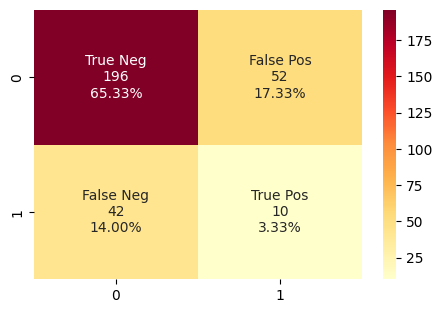

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       248
           1       0.16      0.19      0.18        52

    accuracy                           0.69       300
   macro avg       0.49      0.49      0.49       300
weighted avg       0.71      0.69      0.70       300



Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.83


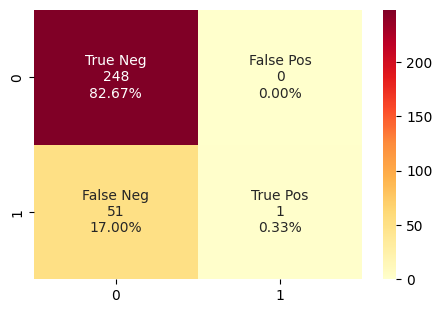

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       248
           1       1.00      0.02      0.04        52

    accuracy                           0.83       300
   macro avg       0.91      0.51      0.47       300
weighted avg       0.86      0.83      0.76       300

Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.7966666666666666


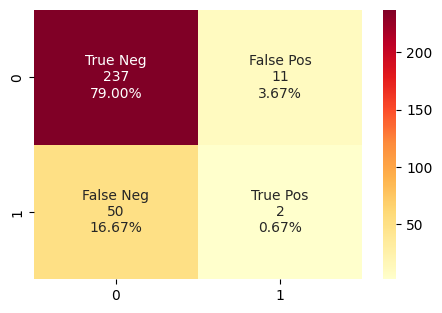

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       248
           1       0.15      0.04      0.06        52

    accuracy                           0.80       300
   macro avg       0.49      0.50      0.47       300
weighted avg       0.71      0.80      0.74       300



In [357]:
build_and_analytics(
    models=[DecisionTreeClassifier(),
            RandomForestClassifier(),
            xgb.XGBClassifier()],
    X_train=x_train_process,
    Y_train=y_train_process,
    X_test=x_test_process,
    Y_test=y_test_process
)

In [358]:
x_train_process.columns

Index(['amount', 'surplus', 'year', 'month', 'day', 'hour', 'minute',
       'method_ATM Card', 'method_Credit Card', 'method_Debit Card',
       'method_Wire Transfer', 'type_du lịch', 'type_mua cổ phiếu',
       'type_mua nhà', 'type_mua sắm', 'type_thanh toán hóa đơn',
       'type_thanh toán học phí', 'type_thanh toán lương', 'type_trả nợ',
       'type_từ thiện', 'type_đóng bảo hiểm'],
      dtype='object')

In [359]:
import pickle
model = pickle.load(open('./DecisionTreeClassifier.pickle', 'rb'))
standardScaler = pickle.load(open('./StandardScaler.pickle', 'rb'))

In [360]:
from datetime import datetime
def getInfoDate(date):
    # Chuyển đổi chuỗi thành đối tượng datetime
    date_time_obj = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

    # Trích xuất ngày, tháng, năm, giờ, phút và giây
    year = date_time_obj.year
    month = date_time_obj.month
    day = date_time_obj.day
    hour = date_time_obj.hour
    minute = date_time_obj.minute

    return year, month, day, hour, minute

def predict_fraud(data, standardScaler, model):
    infodate = getInfoDate(data['createDate'])
    amount = data['amount']
    surplus = data['surplus']
    method = data['method']
    typePay = data['type']
    year = infodate[0]
    month = infodate[1]
    day = infodate[2]
    hour = infodate[3]
    minute = infodate[4]


    method_mapping = {
                    'ATM Card': (1, 0, 0, 0),
                    'Credit Card': (0, 1, 0, 0),
                    'Debit Card': (0, 0, 1, 0),
                    'Wire Transfer': (0, 0, 0, 1)
                }

    method_ATM, method_Credit, method_Debit, method_Wire = method_mapping.get(method, (0, 0, 0, 0))

    type_mapping = {
                    'du lịch': (1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
                    'mua cổ phiếu': (0, 1, 0, 0, 0, 0, 0, 0, 0, 0),
                    'mua nhà': (0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
                    'mua sắm': (0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
                    'thanh toán hóa đơn': (0, 0, 0, 0, 1, 0, 0, 0, 0, 0),
                    'thanh toán học phí': (0, 0, 0, 0, 0, 1, 0, 0, 0, 0),
                    'thanh toán lương': (0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
                    'trả nợ': (0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
                    'từ thiện': (0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
                    'đóng bảo hiểm': (0, 0, 0, 0, 0, 0, 0, 0, 0, 1),
                }
    
    type_dulich, type_cophieu, type_muanha, type_muasam, type_hoadon, type_hocphi, type_luong, type_trano, type_tuthien, type_baohiem = type_mapping.get(typePay, (0,0,0,0,0,0,0,0,0,0))


    data_std = standardScaler.transform([[amount, surplus, year, month, day, hour, minute,
                                         method_ATM, method_Credit, method_Debit, method_Wire,
                                         type_dulich, type_cophieu, type_muanha, type_muasam, 
                                         type_hoadon, type_hocphi, type_luong, type_trano, type_tuthien, type_baohiem]])
    
    predict = model.predict(data_std)

    return predict



In [372]:
data = {
        'transID': '12',
        'fromBankAccount': '0012',
        'toBankAccount': '0013',
        'amount': float(10000000),
        'method': 'ATM Card',
        'status': 'Success',
        'fees': 2.0,
        'surplus': float(29303527.0-10000000),
        'type': 'du lịch',
        'content': 'NGVCK',
        'createDate': '2024-08-20 17:29:00'
    }

predict_fraud(data, standardScaler, model)


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [367]:
38661399+1871.57

38663270.57